# Projekt-Assmair-2

In [1]:
"""Import utilized libraries"""
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import itertools
import prawcore
import requests
import json
import praw

## Aufgabe 1

In [2]:
def load_from_webserver(n: int) -> dict:
    """Loades data from a web server
    
    Loads an n-entries long list of subreddit names and their
    corresponding subscriber count from redditlist.com.
    
    Args:
        n: int number of subreddits to fetch
        
    Returns:
        A dictionary with n-entries, where the key is a subreddit name 
        and the value is the corresponding subscriber count.
    """
    
    print('Load data from web server...')
    part_url = 'http://redditlist.com/sfw?page='
    
    subscribers = {}
    #every page has 125 entries
    for i in range(1, (n+124) // 125 + 1):
        page = requests.get(part_url + str(i))
        soup = BeautifulSoup(page.text, 'html5lib')
    
        listings = soup.find(id='listing-parent')
        sub_list = listings.find_all('div', recursive=False)[1]
   
        for sub in sub_list.find_all(class_='listing-item'):
            name = sub.attrs['data-target-subreddit']
            stat = sub.find(class_='listing-stat')
            subscribers[name] = int(stat.text.replace(',', ''))
            
            if len(subscribers) == n:
                return subscribers    #return after n subreddits

    return subscribers

In [3]:
"""Loads data from file or web server.

Loads the file subscribers.json into the dictionary *subscribers*.
If subscribers.json has less than 1000 entries,
it loads the data from a web server.

Attributes:
    subscribers: A dictionary where the key is a subreddit name,
    and the value is the corresponding subscriber count.
"""

try:
    with open('subscribers.json', 'r') as file:
        print(f'Read file: {file.name}')
        subscribers = json.load(file)

    if len(subscribers) > 999:
        print('Load from file...')
    else:
        raise ValueError(f'File contains too few elements: {len(subscribers)}')
        
except (FileNotFoundError, ValueError) as e:
    print(e)
    subscribers = load_from_webserver(1000)
    
    with open('subscribers.json', 'w') as file:
        print(f"Write to file: {file.name}")
        json.dump(subscribers, file, indent=4)

Read file: subscribers.json
Load from file...


## Aufgabe 2

In [4]:
"""Creates an authorized praw.reddit.Reddit instance.

Attributes:
    reddit: Object to interacting with Reddit's API.

Raises:
    OAuthException: if the authorization has failed.
"""

print('Authorize user...')
reddit = praw.Reddit(
    client_id="hZJOtL-VK7kArgIxbwl-2A",
    client_secret="_G0_h3SBxJy3MEVmYIIpGqN2aUogJQ",
    password="eLkz7b9LpbMZ6wx",
    user_agent="FaPra01512_Aufgabe2",
    username="FaPra01512WS22-23",
)

#Checks if authorized. Raises OAuthException if not authorized
print(f"User {reddit.user.me()} is authorized.")

Authorize user...


Version 7.6.0 of praw is outdated. Version 7.6.1 was released 1 day ago.


User FaPra01512WS22-23 is authorized.


In [5]:
def load_subreddit_moderators_list() -> dict:
    """Loads lists of moderators

    Uses the Reddit API to get the list of moderators
    for every key in subscribers.
     
    Returns:
        A dictionary, where the key is a subreddit name
        and the value is the corresponding list of moderators.
    """
    
    moderatorlists = {}
    print('Load data from Reddit...')
    for sub in subscribers:
        moderatorlists[sub] = []
        for moderator in reddit.subreddit(sub).moderator():
            if moderator.name != 'AutoModerator':
                moderatorlists[sub].append(moderator.name)
                
    return moderatorlists

In [6]:
"""Loads data from file or web server.

Loads the file moderatorlists.json into the dictionary *moderatorlists*.
If the keys from *subscribers* and *moderatorlists* don't match, it loads for every
subreddit in *subscribers* the corresponding list of moderators from reddit.com.

Attributes:
    moderatorlists: A dictionary, where a key is the name of a subreddit and
    a value is the list of its moderators.
"""

try:
    with open('moderatorlists.json') as file:
        print(f'Read file: {file.name}')
        moderatorlists = json.load(file)
        
    if moderatorlists.keys() == subscribers.keys():
        print('Load from file...')
    else:
        raise LookupError('Moderatorlists keys don\'t match subscribers keys')

except (FileNotFoundError, LookupError, ValueError) as e:
    print(e)
    moderatorlists = load_subreddit_moderators_list()
    
    with open('moderatorlists.json', 'w') as file:
        json.dump(moderatorlists, file, indent=4)
        print(f"Write to file: {file.name}")

Read file: moderatorlists.json
Load from file...


## Aufgabe 3

In [7]:
def load_quarantined_subreddits() -> tuple:
    """Load data from reddit.com.
    
    Loads for every subreddit in quarantined_subreddits
    the number of subscribers and the list of moderators.
    If the subreddit is in quarantine,
    then the subscriber count is None.
    
    Returns:
        A tuple with two dictionary. The key for each is a subreddit name.
        The first dictionary contains the subscriber count as the value,
        and the second contains the list of moderators as the value.
    """

    subscribers = {}
    moderatorlists = {}
    print("Load missing data...")
    #Assumes that the subscriber count of a 
    #subreddit in quarantine is hiden. So it has no accessible value.
    for name in quarantined_subreddits:
        try:
            sub = reddit.subreddit(name)
            
            if not sub.quarantine:
                subscribers[name] = sub.subscribers
            else:
                subscribers[name] = None    #accessible if opted in.
        #subreddit banned           
        except prawcore.exceptions.NotFound as e:
            print(e, 'from subreddit', name)
            continue
        #subreddit in quarantine
        except prawcore.exceptions.Forbidden as e:
            sub.quaran.opt_in()
            subscribers[name] = None
            
        moderatorlists[name] = []
        for moderator in sub.moderator():
            if moderator.name != 'AutoModerator':
                moderatorlists[name].append(moderator.name)
        
    return subscribers, moderatorlists

In [8]:
"""Load possible quarantined subreddits from reddit.com.

Loads all subreddit names from quarantined.json
if the are not already in *subscribers* and puts them into *quarantined_subreddits*.
Updates *subscribers* and *modoratolists* with the subreddits given in *quarantined_subreddits*.
If *subscribers* and *modoratolists* are changed, subscribers.json and 
moderatorlists.json get updated too.
"""

quarantined_subreddits = set()
try:
    with open('quarantined.json') as file:
        print(f'Read file: {file.name}')
        quarantined_subreddits = set(json.load(file)).difference(subscribers.keys())
        
except FileNotFoundError as e:
    print(e)

new_subs, new_mods = load_quarantined_subreddits()
    
if new_subs:
    subscribers.update(new_subs)
    with open('subscribers.json', 'w') as file:
        print(f"Write to file: {file.name}")
        json.dump(subscribers, file, indent=4)
        
    moderatorlists.update(new_mods)
    with open('moderatorlists.json', 'w') as file:
        print(f"Write to file: {file.name}")
        json.dump(moderatorlists, file, indent=4)

Read file: quarantined.json
Load missing data...
received 404 HTTP response from subreddit CoronavirusConspiracy


## Aufgabe 4

In [9]:
def overlap(n: int, with_quarantined: bool = True, with_zeros: bool = False) -> list:
    """Calculates the overlap of all subreddit pairs.
    
    Needs itertools.
    
    Args:
        n: length of the list to return.
        with_quarantined: if true, the list contains subreddits in quarantine.
        with_zeros: if true, the list contains pairs with zero overlap.
        
    Returns:
        A list with n entries of subreddit pairs and the value 
        of their overlap.
    """
    
    pairs = list(itertools.combinations(moderatorlists.keys(), 2))
    res_list = []
    
    for sub_i, sub_j in pairs:
        intersec_count = len(set(moderatorlists[sub_i]) & set(moderatorlists[sub_j]))
        union_count = len(set(moderatorlists[sub_i] + moderatorlists[sub_j]))
        
        if (((subscribers[sub_i] or subscribers[sub_j]) is None) 
                and not with_quarantined):
            continue
            
        elif not with_zeros and intersec_count == 0:
            continue
            
        elif union_count == 0:
            res_list.append([sub_i, sub_j, 0.0])
            
        else:
            res_list.append([sub_i, sub_j, intersec_count / union_count])
        
          
    res_list = sorted(res_list, key=lambda tup: tup[2], reverse=True)
    return res_list[:n]

In [10]:
def to_html_table(tmp_list, note) -> list:
    """Converts a given list into an HTML table.
    
    There are already enough moduls that probably do a better job.
    
    Args:
        tmp_list: A list of three values, where the first and second are the name
        of a subreddit and the last is the overlap of the first two.
        note: A string to write after the table.
        
    Returns:
        A list of lines in HTML format.
    """
    
    html_table = [
        '<!DOCTYPE html>',
        '<html>',
        '<style>',
        'table, th, td {',
        '  border:1px solid black;',
        '</style>',
        '<body>',
        '',
        f'<h2 align="center">overlap list TOP {str(len(tmp_list))}</h2>',
        '',
        '<table style="width:100%">',
        '  <tr>',
        '    <th>Subreddit A</th>',
        '    <th>Subreddit B</th>',
        '    <th>overlap</th>',
        '  </tr>',
    ]
    
    for sub_pair in tmp_list:
        html_table.extend([
            '  <tr>',
            f'    <th>{sub_pair[0]}</th>',
            f'    <th>{sub_pair[1]}</th>',
            f'    <th>{sub_pair[2]: .5f}',
            '  </tr>',
        ])
    
    html_table.extend([
        '</table>',
        '',
        f'<p>{note}</p>',
        '',
        '</body>',
        '</html>',
    ])
        
    return html_table

In [11]:
"""Prints three different tables.

Print three different tables in HTML format and saves them
under the names table_top50.html, table_top15_with_quarantined.html,
and table_top15_without_quarantined.html
"""

with open("table_top50.html", "w") as file:
    note = 'with_quarantined: true<br>with_zeros: false'
    html_table = to_html_table(overlap(50), note)
    print(f'Write {file.name}')
    file.writelines(html_table)

with open("table_top15_with_quarantined.html", "w") as file:
    note = 'with_quarantined: true<br>with_zeros: false'
    html_table = to_html_table(overlap(15), note)
    print(f'Write {file.name}')
    file.writelines(html_table)
    
with open("table_top15_without_quarantined.html", "w") as file:
    note = 'with_quarantined: false<br>with_zeros: false'
    html_table = to_html_table(overlap(15, with_quarantined=False), note)
    print(f'Write {file.name}')
    file.writelines(html_table)

Write table_top50.html
Write table_top15_with_quarantined.html
Write table_top15_without_quarantined.html


## Aufgabe 5

Ich habe mich zur Speicherung der Daten für eine Assoziativliste entschieden. Jeder Schlüssel entspricht dem Namen eines Subreddits, der dazugehörige Wert ist wiederum eine Assoziativliste mit zwei Schlüssel-Wert-Paar, für das durchschnittliche Comment-Karma und das durchschnittliche Link-Karma. Für fehlende Werte habe ich im Programm den Wert **None** gewählt, welche beim schreiben der json Datei automatisch in den Wert **null** übersetzt wird. Ich finde den Wert null insofern gut geeignet, da dieser Ausdruck in den meisten Datenbanken für fehlende Werte verwendet wird. Im Allgemeinen ist schon recht gut zu erkennen, wie praktisch Datenbanken für solche Aufgeben sind.

In [12]:
def load_karma() -> bool:
    """Loads karma data from reddit.com
    
    Loads the link- and comment karma for every moderator
    in *moderatrlists* who is not in *moderators*.
    
    Returns:
        True if any data is loaded from reddit.com and false otherwise.
    """
    
    missing_moderators = set().union(*moderatorlists.values()).difference(moderators)
    if not missing_moderators:
        print('Load from file...')
        return False
    
    print(f'Load missing karma from reddit...')
    for mod in missing_moderators:
        redditor = reddit.redditor(mod)

        try:
            link_karma = redditor.link_karma
            comment_karma = redditor.comment_karma
        #if redditor is suspended/banned
        except AttributeError as e:
            link_karma = None 
            comment_karma = None
        #if redditor is shadowbanned or non-existent
        except prawcore.exceptions.NotFound as e:
            link_karma = None 
            comment_karma = None
        #if connection is lost. Raises KeyError in calculate_avg_sub_karma()
        except prawcore.RequestException as e:
            print(e)
            break

        moderators[mod] = {'link-karma' : link_karma, 'comment-karma' : comment_karma}
    
    return True

In [13]:
def calculate_avg_sub_karma() -> dict:
    """Calculates the average karma.
    
    Calculates the average link and comment karma for all subreddits
    in *moderatorlists* based on their moderators.
    
    Returns:
        A dictionary, where the key is a subreddit name,
        and the value is a dictionary by itself, where the key is either 
        'avg_link_karma' or 'avg_comment_karma' and the values are 
        the corresponding average link and average comment karma.
    """
    
    avg_sub_mods_karma = {}
    for sub, mods in moderatorlists.items():
        link_karma_list = []
        comment_karma_list = []
        
        for mod in mods:
            if (moderators[mod]['comment-karma'] or 
                moderators[mod]['link-karma']) is not None:  
                
                comment_karma_list.append(moderators[mod]['comment-karma'])
                link_karma_list.append(moderators[mod]['link-karma'])
                
        if link_karma_list and comment_karma_list:
            avg_comment_karma = sum(comment_karma_list) / len(comment_karma_list)
            avg_link_karma = sum(link_karma_list) / len(link_karma_list)
            avg_sub_mods_karma[sub] = {'avg_link_karma': avg_link_karma,
                                       'avg_comment_karma': avg_comment_karma}
            
    return avg_sub_mods_karma

In [14]:
"""Loads moderators.json.

Reads the file moderators.json. Loads possible missing data from
reddit.com. If there is missing data, moderators.json gets updated too.
Afterward, it calculates the average karma for every subreddit in
moderatorlists.

Attributes:
    avg_sub_mods_karma: A dictionary, where the key is the name of
    a subreddit and the value is the average link and comment karma.
"""

try:
    with open('moderators.json', 'r') as file:
        print(f'Read {file.name}')
        moderators = json.load(file)
except (FileNotFoundError, ValueError) as e:
    print(e)
    moderators = {}


if load_karma():
    with open('moderators.json', 'w') as file:
        json.dump(moderators, file, indent=4)
        print(f'Write {file.name}')
        
avg_sub_mods_karma = calculate_avg_sub_karma()

Read moderators.json
Load from file...


## Aufgabe 6

Für das Einlesen der Daten habe ich mich für Assoziativlisten entschieden, da meiner Meinung nach, damit besser lesbarer Code erstellt werden kann und alle Werte direkt über ihren Namen angesprochen werden können.
Für die Verarbeitung der Daten habe ich mich allerdings für ein numpy Array entschieden.

In [15]:
def get_numpy_array() -> np.ndarray:
    """Returns a numpy array, where every row represents a subreddit.
    The first column is the comment karma, the second is the link karma
    and the third is the subscriber count.
    """
    
    #temporaty lists
    comment_karma = []
    link_karma = []
    subscriber_count = []

    for sub, karma in avg_sub_mods_karma.items():
        comment_karma.append(karma['avg_comment_karma'])
        link_karma.append(karma['avg_link_karma'])
        subscriber_count.append(subscribers[sub])
        
    return np.array([comment_karma, link_karma, subscriber_count], 
                    dtype=np.float).transpose()

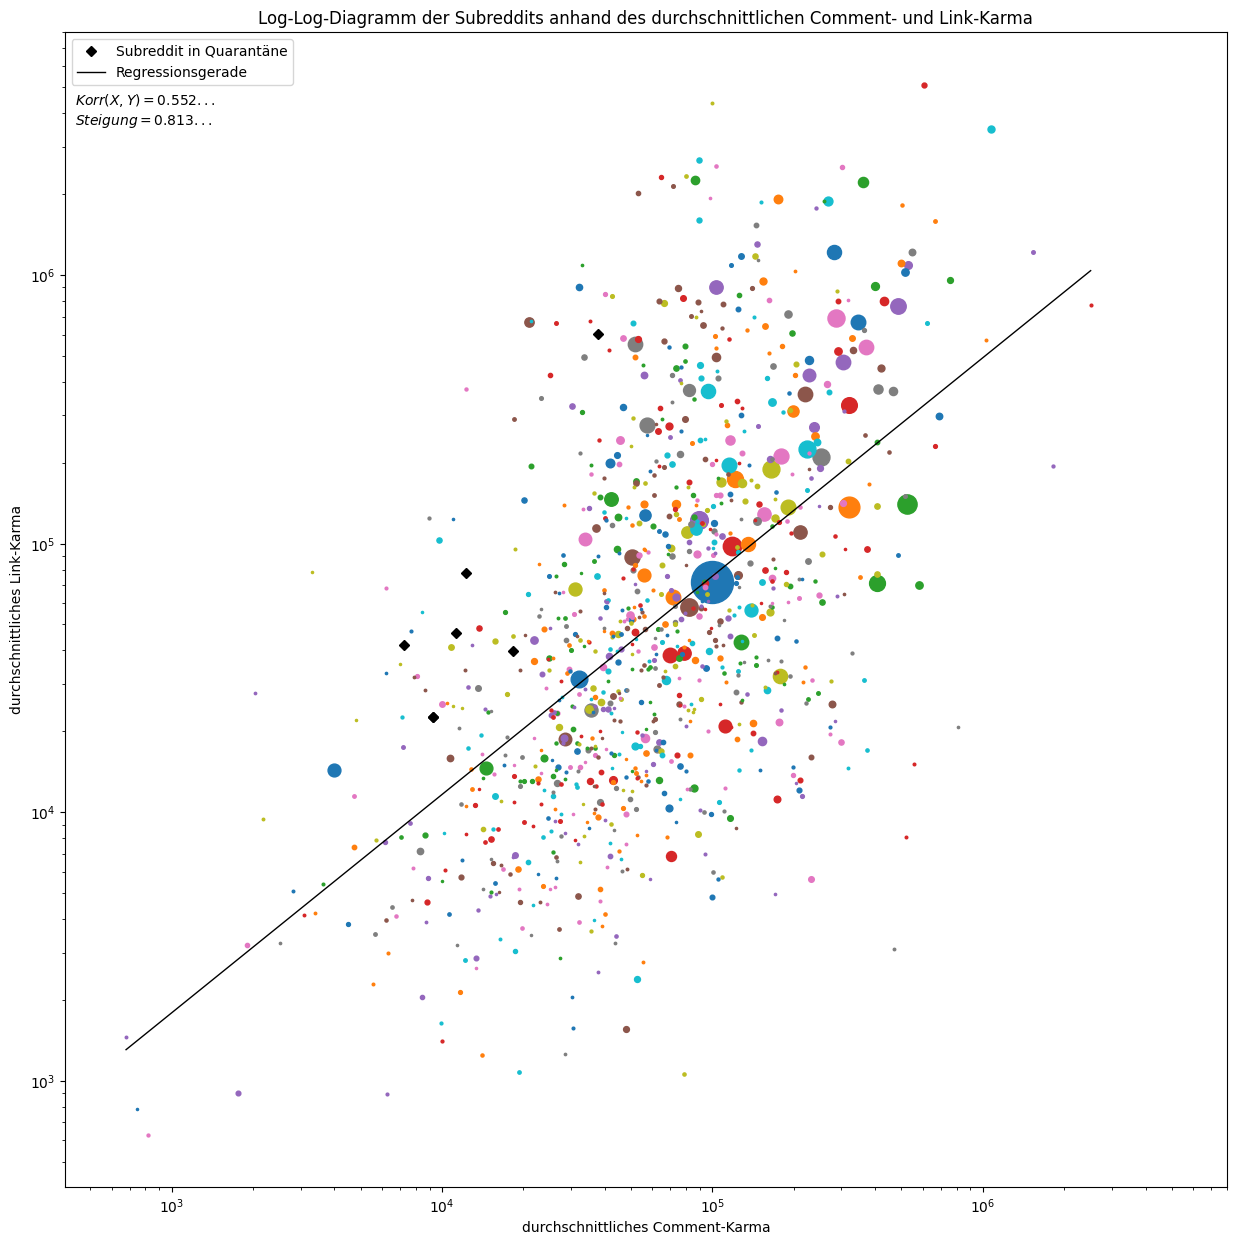

In [16]:
"""Plots the scatter plot of the subreddits.

Draws the scatter plot of the subreddits. The x-axis represents
the average comment karma and the y-axis represents the average link karma.

All values are saved in an array to reuse them for the
calculation of the regression line.
"""

fig, ax = plt.subplots(figsize=(15, 15))
ax.loglog()

#Array with three columns. The first column is the comment karma,
#the second represents the link karma and the third is the subscriber count.
data = get_numpy_array()

for comment_karma, link_karma, subscriber_count in data:
    if np.isnan(subscriber_count):
        sub_q, = ax.plot(comment_karma, link_karma, 
                         'kD', markersize=5)
    
    else:
        plt.plot(comment_karma, link_karma, '.', 
                 markersize=np.sqrt(subscriber_count/50000))

#Calculate linear regressin
xseq = np.logspace(np.log10(min(data[:, 0])), np.log10(max(data[:, 0])))
res = scipy.stats.linregress(np.log10(data[:, 0]), np.log10(data[:, 1]))
#model function: log(Y)=b+m*log(X)
reg, =ax.plot(xseq, 10**res.intercept * xseq**res.slope, color="k", lw=1)

ax.legend([sub_q, reg], ["Subreddit in Quarantäne", "Regressionsgerade"], loc='upper left')
ax.text(21**2, 12.4**6, (f'$Korr(X, Y) = {res.rvalue: .3f}...$\n'
                         f'$Steigung = {res.slope: .3f}...$'))

ax.set_title("Log-Log-Diagramm der Subreddits anhand des durchschnittlichen Comment- und Link-Karma")
ax.set_xlabel("durchschnittliches Comment-Karma")
ax.set_ylabel("durchschnittliches Link-Karma")
ax.set_xlim(ax.get_ylim())

plt.savefig('scatter_plot.pdf')
plt.show()

### Interpretation
> Es ist ein Zusammenhang zwischen dem Comment-Karma und dem Link-Karma zu erkennen. Es handelt sich dabei, wie der Korrelationskoeffizient von ungefähr 0.55 sugeriert, um einen eher schwachen Zusammenhang. Dieser Zusammenhang lässt sich durch das Monom $y = b*x^m$ darstellen. Weder das Comment-Karma noch das Link-Karma stehen, wie im Plot unten zu erkennen ist, in einem ähnlichen Zusammenhang mit der Anzahl der Subscriber.<br>
Interessant finde ich zudem, dass es in der Nähe von $10^7$ Subscribern scheinbar eine Lücke in der Häufigkeit gibt.<br><br>
Zusätzlich möchte ich erwähnen, dass ich versucht habe, so gut es ging, das Ergebnis der Berechnung der Regressionsgeraden zu verifizieren, aber immer noch das Gefühl haben, dass die Steigung zu gering ist. Im Plot sind keine Ausreißer zu erkennen, die eventuell dafür verantwortlich sein könnten.

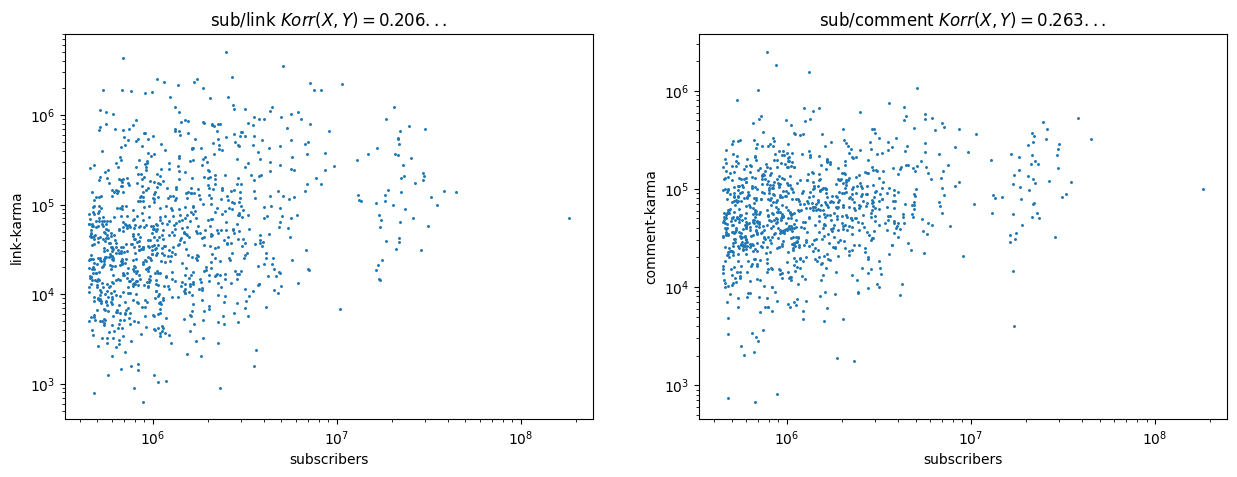

In [17]:
#masks all subreddits with a 'null' value
masked_data = np.ma.masked_invalid(data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.loglog()
ax2.loglog()

ax1.scatter(masked_data[:, 2], masked_data[:, 1], marker='.', s=5)
ax2.scatter(masked_data[:, 2], masked_data[:, 0], marker='.', s=5)

res1 = scipy.stats.linregress(np.log10(masked_data[:, 2]), np.log10(masked_data[:, 1]))
res2 = scipy.stats.linregress(np.log10(masked_data[:, 2]), np.log10(masked_data[:, 0]))

ax1.set_title(f'sub/link $Korr(X,Y)={res1.rvalue: .3f}...$')
ax1.set_xlabel('subscribers')
ax1.set_ylabel('link-karma')
ax2.set_title(f'sub/comment $Korr(X,Y)={res2.rvalue: .3f}...$')
ax2.set_xlabel('subscribers')
ax2.set_ylabel('comment-karma')

plt.show()